**Install** **cell**



In [1]:
!pip install sentence-transformers
!pip install umap-learn
!pip install umap-learn[plot]
!pip install --pre umap-learn
!pip install hdbscan
!pip install numba
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 31.7 MB/s 
     |████████████████████████████████| 6.8 MB 30.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.6 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 38.5 MB/s 
     |████████████████████████████████| 895 kB 48.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=09199913a07f06d7417a95602003b8239a7105237a19ee0bafd383c72f26df6f
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 37.6 MB/s 
  Crea

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import matplotlib
import matplotlib.pyplot as plt
import math
import re
import numpy as np
import umap
import umap.plot
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import nltk
from google.colab import files
import io
from numba import jit,njit,vectorize,cuda,uint32,f8,uint8
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
#plotly imports
import collections
from collections import Counter
import string
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot #make plotly work in notebook
init_notebook_mode(connected = True)
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab' #make plotly work in colab

In [4]:
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['spiegel_articles_12_2021.csv']))

Saving spiegel_articles_12_2021.csv to spiegel_articles_12_2021.csv


**Data preprocessing / data cleaning**

In [5]:
def preprocess(data,col_names):

  #rename data columns
  data = data.set_axis(names, axis=1)
  #Remove NaN values on Article_text column
  data = data.dropna(subset=["Article_Text"])

  return data

names = ['url','Article_Title','Article_Text','Article_Author','Article_News_Agency_Source','Date_published','Date_modified','Category','Article_Type','Article_Keywords','Paywall_status','Article_unique_ID','Intro_paragraph_for_the_article','Index','categorisation_of_the_article_source','article_text_length','article_text_length_category','Extracted_index','extracted_follow_arguments']
data = preprocess(data,names)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3283 entries, 0 to 3334
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   url                                   3283 non-null   object 
 1   Article_Title                         3283 non-null   object 
 2   Article_Text                          3283 non-null   object 
 3   Article_Author                        2789 non-null   object 
 4   Article_News_Agency_Source            1375 non-null   object 
 5   Date_published                        3283 non-null   object 
 6   Date_modified                         3283 non-null   object 
 7   Category                              3283 non-null   object 
 8   Article_Type                          3283 non-null   object 
 9   Article_Keywords                      3283 non-null   object 
 10  Paywall_status                        3283 non-null   bool   
 11  Article_unique_ID

**Topic** **Creation** c-TF-IDF

we treat all documents in a single cluster as a single document and then apply TF-IDF, The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic

In [6]:
#TF-IDF (c-TF-IDF) score allows to extract what makes each set of documents unique compared to the other 
#by comparing the importance of words between documents
def c_tf_idf(documents, m, ngram_range):

    #ngram_range=(2, 3) works on bi/tri grams
    german_stop_words = stopwords.words('german')
    english_stop_words = stopwords.words('english')
    extra = ['denen','deren','gut','schlecht','wurde','wurden','schon', 'wohl', 'ab', 'sei', 'seien', 'seit','immer', 'ersten',
         'sowie','sowohl', 'müssen', 'sollen', 'dürfen', 'können', 'dabei']
    stop_words= german_stop_words + english_stop_words + extra
    #remove all german stop words when calculating the count
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [7]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}

    return top_n_words

def extract_topic_sizes(df,top_n_words):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    top_words_per_topic = ['/'.join([word[0] for word in top_n_words[topic]]) for topic in topic_sizes.Topic.values]
    topic_sizes["Top_words"] = top_words_per_topic
    topic_sizes.index = list(range(len(topic_sizes)))
    for i in topic_sizes.index:
      df.loc[df["Topic"]==topic_sizes.at[i,'Topic'], ["Top_words"]]=topic_sizes.at[i,'Top_words']
    df.loc[df["Topic"]==-1,['Top_words']]=None

    return topic_sizes

In [8]:
def extract_useful_data(data,cluster):

  #create a single document for each cluster of documents
  docs_df = data[['url','Article_Text','Category']].copy()
  docs_df=docs_df.rename(columns={"Article_Text":"Doc"})
  docs_df['Topic'] = cluster.labels_
  docs_df['Probability'] = cluster.probabilities_
  docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

  return docs_df,docs_per_topic

In [9]:
def get_cosine_sim(text1, text2):

  WORD = re.compile(r"\w+")

  vec1 = Counter(WORD.findall(text1))
  vec2 = Counter(WORD.findall(text2))

  intersection = set(vec1.keys()) & set(vec2.keys())
  numerator = sum([vec1[x] * vec2[x] for x in intersection])

  sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
  sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
  denominator = math.sqrt(sum1) * math.sqrt(sum2)

  if not denominator:
    return 0.0
  else:
    return float(numerator) / denominator

**Clustering** **GPU** **is** **needed** 


Before doing so, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly : **UMAP**

In [10]:
def transform(data,embeddings):

  #Due to the stochastisch nature of UMAP, the results from topic modeling might differ 
  #and the quality can degrade, try several times ( reclustering == rerun the umap function)
  #until you find the topics that suit best
  umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

  cluster = hdbscan.HDBSCAN(min_cluster_size=15,metric='euclidean',cluster_selection_method='eom').fit(umap_embeddings)

  #visualize clusters
  mapper = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
  umap.plot.points(mapper, labels = cluster.labels_, theme='fire')

  return cluster

In [11]:
#used when there is no embeddings
@jit
def fit_transform(data):

  #Embeddings : converting the documents to numerical data
  model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
  embeddings = model.encode(data.Article_Text.tolist(), show_progress_bar=True)

  cluster = transform(data,embeddings)
  
  return cluster

In [12]:
def reduce_topics(iter,tf_idf,docs_df,docs_per_topic,old_topic_sizes):

  #merge the most similar topics together
  for i in range(iter):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_to_merge = old_topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m,ngram_range=(2, 3))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df,top_n_words)

    print("number of topics before reduction : "+str(len(old_topic_sizes[old_topic_sizes.Topic != -1])))
    print("number of topics after reduction : "+str(len(topic_sizes[topic_sizes.Topic != -1])))

    return top_n_words,topic_sizes,docs_df,docs_per_topic

In [13]:
def plot_top_words_for_top_topics(top_n_words,topic_sizes,n,n_words):

  #view the words belonging to the top n largest clusters
  #n_words : number of top words to plot
  #change the number n to any number you want

  if n_words > 20:
    raise ValueError('The number of top words to plot should be less than 20')
  topics = topic_sizes[1:n+1].Topic.values
  plot_titles = ["topic " + str(topic) for topic in topics]
  topic_words=[top_n_words[topic][:n_words] for topic in topics]
  fig = make_subplots(rows=int(n/2)+1, cols=2, shared_yaxes=False, subplot_titles = plot_titles)
  row = 1
  col = 1
  diff = 0
  counter = 1
  for words in topic_words:
    fig.add_trace(go.Bar(x=[word[0] for word in words],
                       y=[word[1] for word in words],
                       marker=dict(color=[1, 2, 3,4,5])),row, col)
    if (counter)%2 != 0 :
      col +=1
      diff +=1
    else:
      row+=1
      col = row - diff
    counter +=1
  fig.update_layout(
  xaxis = dict(showgrid = False), yaxis = dict(showgrid = False), plot_bgcolor = "white")
  fig.show()

In [14]:
def visualize_topics(data,n,nb,topic_sizes,n_words):

  #n is the number of largest topics we want to plot its docs , for exmp n=2 , the top 2 largest topic 
  #nb the number of random docs to be plotted in a single cluster

  if n_words > 20:
        raise ValueError('The number of top words is up to 20 words')
  print("\t\t\t\t\t"+str(len(topic_sizes[topic_sizes.Topic != -1]))+" topics clustered out of "+str(len(data))+" articles\n")
  k=0
  for i in topic_sizes.index[1:n+1]:
    k+=1
    topic = topic_sizes.at[i,'Topic']
    d = data[data.Topic==topic][['url','Probability']].copy()
    wordslist = topic_sizes.at[i,'Top_words']
    words = wordslist.split('/')[:n_words]
    all_words =' '.join([word.replace(' ','_') for word in words])
    wordcloud = WordCloud(width=800, height=500, random_state=100, max_font_size=110).generate(all_words)
    print("\t\t\t\tCluster "+str(k))
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    print("\n")
    if(len(d) >= nb):
      print(d.head(nb))
    else:
      print(d.head())
    print("\n")

In [15]:
def plot_topics(topic_sizes,top_n_words,n_words):

  topic_sizes = topic_sizes[topic_sizes.Topic != -1] #remove the unassigned topic
  top_words_per_topic = ['/'.join([word[0] for word in top_n_words[topic][:n_words]]) for topic in topic_sizes.Topic.values]
  fig = px.bar(topic_sizes, y='Size', x='Topic', hover_name = top_words_per_topic)
  fig.update_layout(
  xaxis = dict(dtick = 1, showgrid = False), yaxis = dict(showgrid = False), plot_bgcolor = "white", title_text = "documents per clusified topic")
  fig.update_traces(marker_color='black')
  fig.show()

Batches:   0%|          | 0/103 [00:00<?, ?it/s]

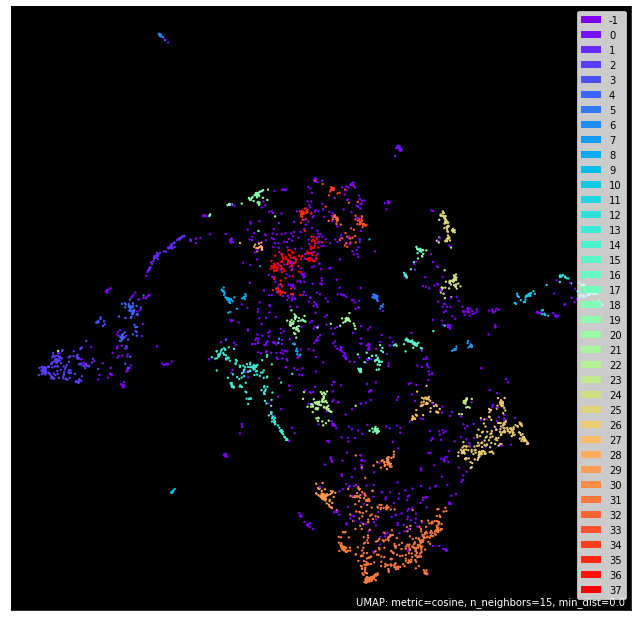

In [29]:
cluster = fit_transform(data)

In [30]:
docs_df,docs_per_topic = extract_useful_data(data,cluster)

In [31]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data.Article_Text), ngram_range=(2, 3))

In [32]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df,top_n_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [34]:
topic_sizes.head()

,Topic,Size,Top_words
0,-1,1028,millionen euro/new york/milliarden euro/jahre ...
1,31,418,omikron variante/covid 19/bund länder/robert k...
2,26,211,olaf scholz/angela merkel/friedrich merz/walte...
3,13,166,boris johnson/downing street/lesen mehr tod/me...
4,2,161,champions league/fc bayern/premier league/boru...


In [35]:
new_top_n_words,new_topic_sizes,docs_df,docs_per_topic = reduce_topics(20,tf_idf,docs_df,docs_per_topic,topic_sizes)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



number of topics before reduction : 38
number of topics after reduction : 37


In [36]:
new_topic_sizes.head()

,Topic,Size,Top_words
0,-1,1028,millionen euro/new york/milliarden euro/jahre ...
1,30,418,omikron variante/covid 19/bund länder/robert k...
2,25,211,olaf scholz/angela merkel/friedrich merz/walte...
3,2,177,champions league/fc bayern/premier league/boru...
4,12,166,boris johnson/downing street/lesen mehr tod/me...


In [23]:
plot_top_words_for_top_topics(new_top_n_words,new_topic_sizes,6,10)

					40 topics clustered out of 3283 articles

				Cluster 1


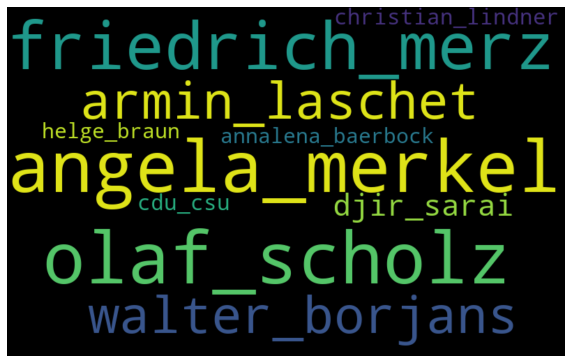



                                                   url  Probability
6    https://www.spiegel.de/politik/deutschland/pol...     1.000000
127  https://www.spiegel.de/politik/deutschland/afd...     0.705432
156  https://www.spiegel.de/politik/deutschland/omi...     1.000000
162  https://www.spiegel.de/panorama/wie-ich-armin-...     1.000000
178  https://www.spiegel.de/politik/deutschland/vol...     0.942698
180  https://www.spiegel.de/politik/deutschland/so-...     1.000000
222  https://www.spiegel.de/kultur/tv/olli-dittrich...     0.894848
232  https://www.spiegel.de/panorama/armin-laschet-...     1.000000
239  https://www.spiegel.de/politik/deutschland/das...     0.834559
282  https://www.spiegel.de/panorama/gesellschaft/n...     0.757360


				Cluster 2


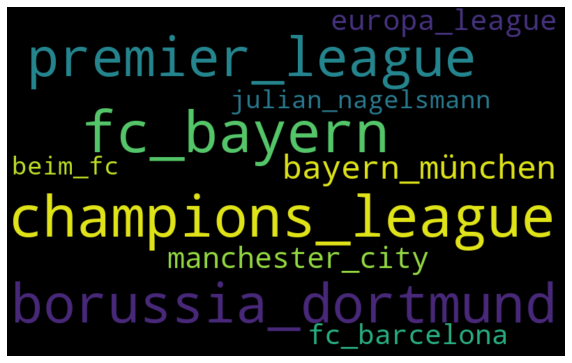



                                                   url  Probability
33   https://www.spiegel.de/sport/fussball/premier-...     0.467692
45   https://www.spiegel.de/panorama/leute/joao-can...     0.471353
81   https://www.spiegel.de/sport/fussball/ligue-1-...     0.581054
153  https://www.spiegel.de/sport/fussball/felix-zw...     0.603413
192  https://www.spiegel.de/familie/paris-saint-ger...     0.447348
224  https://www.spiegel.de/sport/fussball/fc-bayer...     0.579983
244  https://www.spiegel.de/panorama/leute/cristian...     0.478887
291  https://www.spiegel.de/sport/fussball/borussia...     0.606014
325  https://www.spiegel.de/sport/fussball/bundesli...     0.747232
369  https://www.spiegel.de/sport/fussball/von-manc...     0.613442


				Cluster 3


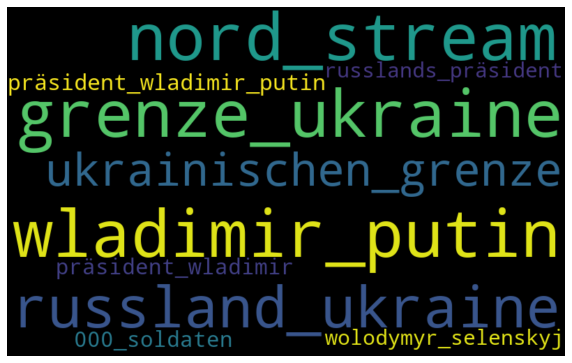



                                                   url  Probability
2    https://www.spiegel.de/ausland/jahresausblick-...     0.414327
50   https://www.spiegel.de/ausland/manfred-weber-d...     0.353237
201  https://www.spiegel.de/ausland/spannungen-an-u...     0.621051
217  https://www.spiegel.de/wirtschaft/nord-stream-...     0.291291
218  https://www.spiegel.de/politik/deutschland/cla...     0.355759
242  https://www.spiegel.de/ausland/bundesregierung...     0.529341
250  https://www.spiegel.de/ausland/ukraine-wolodym...     0.404673
285  https://www.spiegel.de/ausland/russland-gerich...     0.365383
303  https://www.spiegel.de/ausland/ukraine-konflik...     0.825021
307  https://www.spiegel.de/ausland/russland-moskau...     0.418082


				Cluster 4


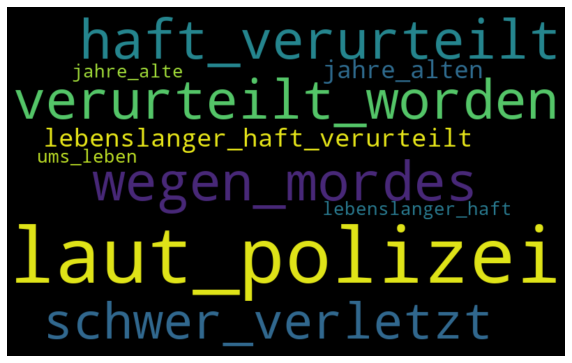



                                                   url  Probability
20   https://www.spiegel.de/panorama/justiz/haftstr...     1.000000
30   https://www.spiegel.de/panorama/baden-wuerttem...     1.000000
74   https://www.spiegel.de/politik/deutschland/vid...     0.878452
106  https://www.spiegel.de/panorama/justiz/hamburg...     1.000000
136  https://www.spiegel.de/panorama/justiz/bayern-...     0.909723
234  https://www.spiegel.de/panorama/justiz/halle-a...     0.985753
272  https://www.spiegel.de/panorama/justiz/fischer...     0.929765
289  https://www.spiegel.de/panorama/justiz/polizei...     1.000000
302  https://www.spiegel.de/panorama/justiz/a2-bei-...     0.897156
308  https://www.spiegel.de/panorama/justiz/fischer...     0.961027




In [24]:
visualize_topics(docs_df,4,10,new_topic_sizes,10)

In [25]:
plot_topics(new_topic_sizes,new_top_n_words,4)

In [26]:
def recluster_outlier(df,old_topic_sizes,old_top_n_words,threshold):

  #threshold is a minimum value of cosine similarity between 2 topics      
  d= df[df.Topic == -1]
  d=d.rename(columns={"Doc":"Article_Text"})
  cluster = fit_transform(d)
  docs_df,docs_per_topic = extract_useful_data(d,cluster)
  tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(d.Article_Text), ngram_range=(2, 3))
  top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
  topic_sizes = extract_topic_sizes(docs_df,top_n_words)
  new_top_n_words,new_topic_sizes,docs_df,docs_per_topic = reduce_topics(20,tf_idf,docs_df,docs_per_topic,topic_sizes)
  old_topic_sizes=old_topic_sizes.drop([0])
  l = len(old_topic_sizes)
  old_top_n_words.pop(-1)
  old_topic_sizes['Added_words']=" "
  test = True
  old_topic_sizes=old_topic_sizes.append(new_topic_sizes.iloc[0], ignore_index=True)
  old_top_n_words[-1]= new_top_n_words[new_topic_sizes.at[0,'Topic']]
  for i in new_topic_sizes.index[1:]:
    t = max(old_topic_sizes.Topic.values)+1
    for j in old_topic_sizes.index[:l]:
      comm  = get_cosine_sim(new_topic_sizes.at[i,'Top_words'].replace('/',' '),old_topic_sizes.at[j,'Top_words'].replace('/',' '))
      if (comm > threshold and new_topic_sizes.at[i,'Topic']!=-1):
        unique = new_topic_sizes.at[i,'Top_words']
        size = old_topic_sizes.at[j,'Size'] + new_topic_sizes.at[i,'Size']
        old_topic_sizes.loc[old_topic_sizes["Topic"]==old_topic_sizes.at[j,'Topic'],['Size']]=size
        old_topic_sizes.loc[old_topic_sizes["Topic"]==old_topic_sizes.at[j,'Topic'],['Added_words']]=unique
        #df.loc[]
        test = False
        break
    if test :
      row = {'Topic': t, 'Size': new_topic_sizes.at[i,'Size'], 'Top_words': new_topic_sizes.at[i,'Top_words'], 'Added_words': " "}
      old_topic_sizes=old_topic_sizes.append(row, ignore_index=True)
      old_top_n_words[t]= new_top_n_words[new_topic_sizes.at[i,'Topic']]
  #plot_top_words_for_top_topics(new_top_n_words,new_topic_sizes,4,10)
  #visualize_topics(docs_df,4,5,new_topic_sizes,10)
  #plot_topics(new_topic_sizes,new_top_n_words,4)

  old_topic_sizes=old_topic_sizes.sort_values("Size", ascending=False).reset_index(drop=True)
  #words,topics,docs_df,docs_per_topic = reduce_topics(20,tf_idf,docs_df,docs_per_topic,old_topic_sizes)

  return old_topic_sizes

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



number of topics before reduction : 9
number of topics after reduction : 8


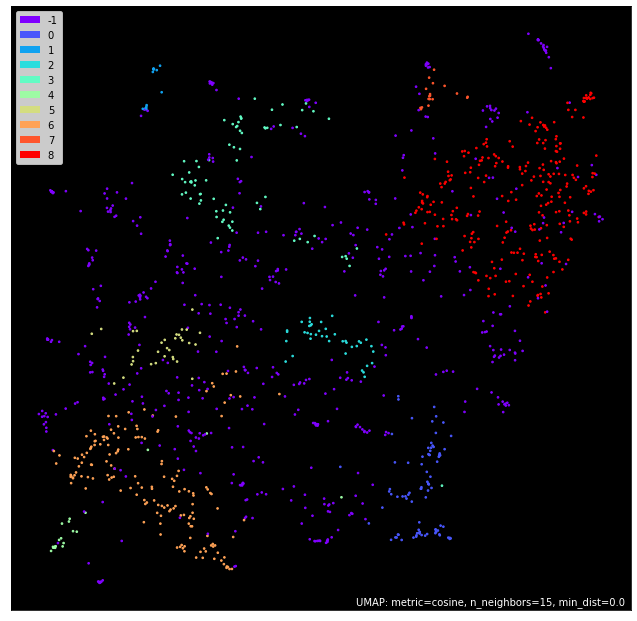

In [27]:
topics = recluster_outlier(docs_df,new_topic_sizes,new_top_n_words,0.4)

In [28]:
topics

,Topic,Size,Top_words,Added_words
0,-1,603,anzeige bücher/millionen euro/thomas plaßmann/...,NaN
1,39,365,allgemeine impfpflicht/omikron variante/impfen...,omikron variante/covid 19/impfen lassen/karl l...
2,26,209,angela merkel/olaf scholz/friedrich merz/walte...,
3,3,173,champions league/fc bayern/borussia dortmund/p...,
4,9,108,wladimir putin/grenze ukraine/nord stream/russ...,
5,35,94,laut polizei/verurteilt worden/wegen mordes/ha...,
6,13,86,lesen mehr tod/mehr tod/lesen mehr/april 2021/...,
7,23,67,elon musk/wartburg 353/000 euro/herbert diess/...,
8,2,66,peng shuai/olympischen winterspiele/diplomatis...,
9,19,64,frau deicke/dinner one/spieler innen/innen jah...,
